# Data Cleaning

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

In this notebook, we focus on the data cleaning process. The main steps involved in this process include:

1. **Deletion of Rows**: We identify and remove rows and irrelevant records to ensure the dataset's integrity and relevance.

2. **Imputation of Null Values**: We handle missing data by imputing values based on various strategies.

3. **Cleaning of Erroneous Data**: We correct any erroneous data points, such as negative or inconsistent values, to maintain data accuracy.

4. **Type Conversion**: After the data understanding, we ensure that all columns have the appropriate data types, converting columns as necessary to facilitate further analysis.

These steps are crucial to prepare the dataset for subsequent analysis and modeling, ensuring that the data is accurate, complete, and consistent.

In [1]:
# Autoreload allows the notebook to dynamically load code: if we update some helper functions *outside* of the notebook, we do not need to reload the notebook.
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from unidecode import unidecode
import math

import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

## Cyclists

In [4]:
csv_file = "../data/cyclists.csv"
cyclists_dataset = pd.read_csv(csv_file)
cyclists_dataset.head()

,_url,name,birth_year,weight,height,nationality
0,bruno-surra,Bruno Surra,1964.0,NaN,NaN,Italy
1,gerard-rue,Gérard Rué,1965.0,74.0,182.0,France
2,jan-maas,Jan Maas,1996.0,69.0,189.0,Netherlands
3,nathan-van-hooydonck,Nathan Van Hooydonck,1995.0,78.0,192.0,Belgium
4,jose-felix-parra,José Félix Parra,1997.0,55.0,171.0,Spain


In [5]:
cyclists_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6134 entries, 0 to 6133
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   _url         6134 non-null   object 
 1   name         6134 non-null   object 
 2   birth_year   6121 non-null   float64
 3   weight       3078 non-null   float64
 4   height       3143 non-null   float64
 5   nationality  6133 non-null   object 
dtypes: float64(3), object(3)
memory usage: 287.7+ KB


### Modify columns

Before cleaning the cyclists dataset, we redefine the dataframe with the new types, for the reason explained in the data understanding process.

In [6]:
# set birth year to int
cyclists_dataset['birth_year'] = cyclists_dataset[cyclists_dataset['birth_year'].notnull()]['birth_year'].astype(int)
cyclists_dataset['birth_year'].dtype

dtype('float64')

### Imputation

In [7]:
cyclists_dataset.isnull().sum() # check number of missing values

_url              0
name              0
birth_year       13
weight         3056
height         2991
nationality       1
dtype: int64

#### Imputation of `birth_year` and `nationality` null values

For the missing birth year and nationality, we tried to manually retrieve as much data as possible through online searches.

In [8]:
# Show urls of the cyclists with 'birth_year' missing values
cyclists_dataset[cyclists_dataset['birth_year'].isnull()]['_url']

9             scott-davies
601       vladimir-malakov
894         antonio-zanini
2408     filippo-simonetti
2515         carlos-garcia
2536       alexandr-osipov
3046      nicolai-kosyakov
3551            nevens-guy
4142           oscar-pumar
4384         javier-luquin
4756        thierry-lauder
6072    sergei-jermachenko
6080       batik-odriozola
Name: _url, dtype: object

For the birth years found, we manually imputed the obtained value into the corresponding 'birth_year' feature.

In [9]:
cyclists_dataset.loc[cyclists_dataset['_url'] == 'scott-davies', 'birth_year'] = 1995
cyclists_dataset.loc[cyclists_dataset['_url'] == 'vladimir-malakov', 'birth_year'] = 1958
cyclists_dataset.loc[cyclists_dataset['_url'] == 'antonio-zanini', 'birth_year'] = 1965
cyclists_dataset.loc[cyclists_dataset['_url'] == 'nevens-guy', 'birth_year'] = 1962
cyclists_dataset.loc[cyclists_dataset['_url'] == 'sergei-jermachenko', 'birth_year'] = 1956 

Similar reasoning was applied for nationality. The only missing value belonged to the cyclist Scott Davies.

In [10]:
cyclists_dataset.loc[cyclists_dataset['_url'] == 'scott-davies', 'nationality'] = 'Great Britain'

For the remaining birth years, the mode was used

In [11]:
cyclists_dataset['birth_year'] = cyclists_dataset['birth_year'].fillna(cyclists_dataset['birth_year'].mode()[0]) # substitue 8 remaining elements with mode

In [12]:
cyclists_dataset['birth_year'].isnull().sum() # check if missing values are filled correctly

np.int64(0)

#### Imputation of `weight` and `height` null values

Knowing that height and weight are highly correlated, we can use weight to find height, and height to find weight.

In [13]:
# Filter rows where 'weight' is null and 'height' is not null
missing_weight_with_height = cyclists_dataset[cyclists_dataset['weight'].isnull() & cyclists_dataset['height'].notnull()]
print("Cyclists where we have only the height:", len(missing_weight_with_height))

# Filter rows where 'weight' is not null and 'height' is null
missing_height_with_weight = cyclists_dataset[cyclists_dataset['weight'].notnull() & cyclists_dataset['height'].isnull()]
print("Cyclists where we have only the weight:", len(missing_height_with_weight))


Cyclists where we have only the height: 72
Cyclists where we have only the weight: 7


For this imputation, we considered two possible methods. One is to create a small linear regression model, and the other is to base it on the mean of the distributions divided into various bins.

In [14]:
def linear_regression_imputation():
    available_data = cyclists_dataset.dropna(subset=['weight', 'height']) # Filter out rows with missing values in weight or height

    # Fit regression model to predict weight based on height and calculate residuals
    model_weight = LinearRegression()
    model_weight.fit(available_data[['height']], available_data['weight'])
    weight_predicted = model_weight.predict(available_data[['height']])
    weight_residuals = available_data['weight'] - weight_predicted

    # Fit regression model to predict height based on weight and calculate residuals
    model_height = LinearRegression()
    model_height.fit(available_data[['weight']], available_data['height'])
    height_predicted = model_height.predict(available_data[['weight']])
    height_residuals = available_data['height'] - height_predicted

    # Function to impute weight based on height
    def impute_weight(height):
        height_df = pd.DataFrame([[height]], columns=['height'])
        predicted_weight = model_weight.predict(height_df)[0]
        imputed_weight = predicted_weight + np.random.choice(weight_residuals)
        return imputed_weight

    # Function to impute height based on weight
    def impute_height(weight):
        weight_df = pd.DataFrame([[weight]], columns=['weight'])
        predicted_height = model_height.predict(weight_df)[0]
        imputed_height = predicted_height + np.random.choice(height_residuals)
        return imputed_height

    imputed_dataset = cyclists_dataset.copy()

    # Apply imputation for cyclists with available height but missing weight
    imputed_dataset.loc[imputed_dataset['weight'].isnull() & imputed_dataset['height'].notnull(), 'weight'] = \
        imputed_dataset.loc[imputed_dataset['weight'].isnull() & imputed_dataset['height'].notnull(), 'height'].apply(impute_weight)
    # Apply imputation for cyclists with available weight but missing height
    imputed_dataset.loc[imputed_dataset['height'].isnull() & imputed_dataset['weight'].notnull(), 'height'] = \
        imputed_dataset.loc[imputed_dataset['height'].isnull() & imputed_dataset['weight'].notnull(), 'weight'].apply(impute_height)

    return imputed_dataset

imputed_dataset_lr = linear_regression_imputation()

imputed_dataset_lr.isnull().sum() # check if missing values are filled correctly

_url              0
name              0
birth_year        0
weight         2984
height         2984
nationality       0
dtype: int64

In [15]:
def bins_imputation():
    imputed_dataset = cyclists_dataset.copy()

    # Create bins for height and weight (we use deciles)
    imputed_dataset['height_bin'] = pd.qcut(imputed_dataset['height'], q=10)  # deciles for height
    imputed_dataset['weight_bin'] = pd.qcut(imputed_dataset['weight'], q=10)  # deciles for weight

    height_weight_means = imputed_dataset.groupby('height_bin')['weight'].mean() # Mean weight for each height bin
    weight_height_means = imputed_dataset.groupby('weight_bin')['height'].mean() # Mean height for each weight bin

    # Function to impute weight based on height bin
    def impute_weight_simple(row):
        if pd.isnull(row['weight']) and pd.notnull(row['height']):
            return height_weight_means[row['height_bin']]
        return row['weight']

    # Function to impute height based on weight bin
    def impute_height_simple(row):
        if pd.isnull(row['height']) and pd.notnull(row['weight']):
            return weight_height_means[row['weight_bin']]
        return row['height']

    # Apply imputation functions
    imputed_dataset['weight'] = imputed_dataset.apply(impute_weight_simple, axis=1)
    imputed_dataset['height'] = imputed_dataset.apply(impute_height_simple, axis=1)

    imputed_dataset.drop(columns=['height_bin', 'weight_bin'], inplace=True) # Remove support columns

    return imputed_dataset

imputed_dataset_bins = bins_imputation()

imputed_dataset_bins[['weight', 'height']].isnull().sum() # check if missing values are filled correctly

weight    2984
height    2984
dtype: int64

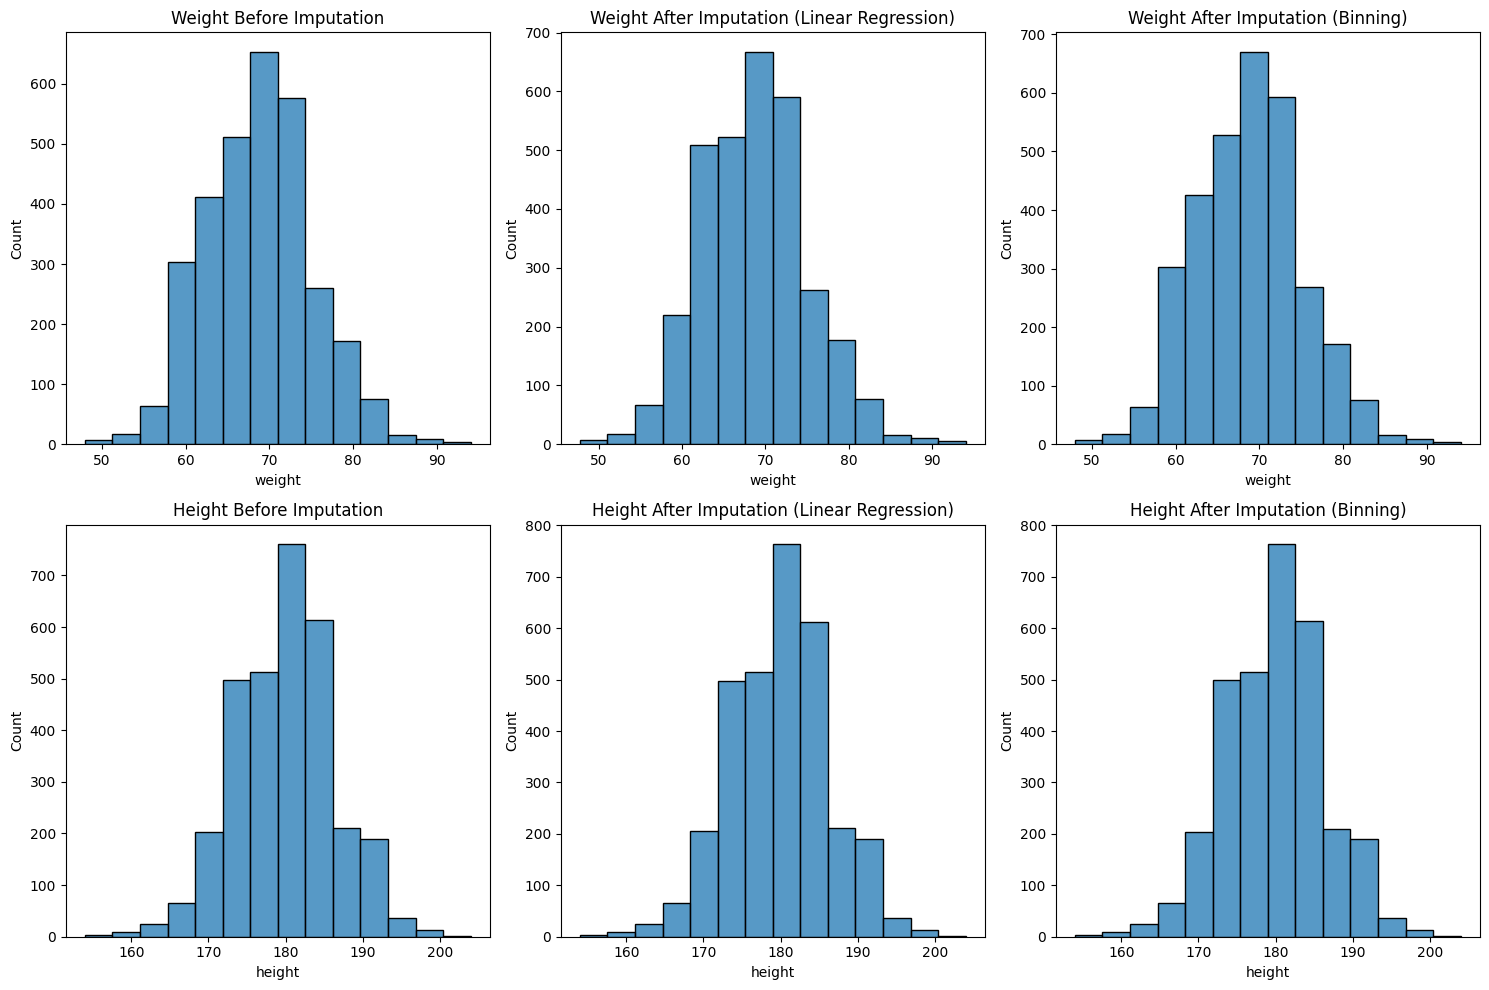

In [16]:
n_bins = math.ceil(math.log2(len(cyclists_dataset)) + 1) 
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

sb.histplot(data=cyclists_dataset, x="weight", bins=n_bins, ax=axes[0, 0])
axes[0, 0].set_title("Weight Before Imputation")

sb.histplot(data=imputed_dataset_lr, x="weight", bins=n_bins, ax=axes[0, 1])
axes[0, 1].set_title("Weight After Imputation (Linear Regression)")

sb.histplot(data=imputed_dataset_bins, x="weight", bins=n_bins, ax=axes[0, 2])
axes[0, 2].set_title("Weight After Imputation (Binning)")


sb.histplot(data=cyclists_dataset, x="height", bins=n_bins, ax=axes[1, 0])
axes[1, 0].set_title("Height Before Imputation")

sb.histplot(data=imputed_dataset_lr, x="height", bins=n_bins, ax=axes[1, 1])
axes[1, 1].set_title("Height After Imputation (Linear Regression)")

sb.histplot(data=imputed_dataset_bins, x="height", bins=n_bins, ax=axes[1, 2])
axes[1, 2].set_title("Height After Imputation (Binning)")

plt.tight_layout()
plt.show()

Both methods correctly impute the values of interest. Additionally, we notice from the distributions that there is not a significant difference, but the imputation with the second method maintains a distribution more consistent with the initial one. Therefore, we will perform the imputation using the mean in the distribution.

In [17]:
# Create bins for height and weight (we use deciles)
cyclists_dataset['height_bin'] = pd.qcut(cyclists_dataset['height'], q=10)
cyclists_dataset['weight_bin'] = pd.qcut(cyclists_dataset['weight'], q=10)

height_weight_means = cyclists_dataset.groupby('height_bin')['weight'].mean() # Mean weight for each height bin
weight_height_means = cyclists_dataset.groupby('weight_bin')['height'].mean() # Mean height for each weight bin

# Function to impute weight based on height bin
def impute_weight_simple(row):
    if pd.isnull(row['weight']) and pd.notnull(row['height']):
        return height_weight_means[row['height_bin']]
    return row['weight']

# Function to impute height based on weight bin
def impute_height_simple(row):
    if pd.isnull(row['height']) and pd.notnull(row['weight']):
        return weight_height_means[row['weight_bin']]
    return row['height']

# Apply imputation functions
cyclists_dataset['weight'] = cyclists_dataset.apply(impute_weight_simple, axis=1)
cyclists_dataset['height'] = cyclists_dataset.apply(impute_height_simple, axis=1)

cyclists_dataset.drop(columns=['height_bin', 'weight_bin'], inplace=True) # Remove support columns

# Round weight to one decimal and height to zero decimals
cyclists_dataset['weight'] = cyclists_dataset['weight'].round(1)
cyclists_dataset['height'] = cyclists_dataset['height'].round(0)

In [18]:
cyclists_dataset[['weight', 'height']].isnull().sum() # check if missing values are filled correctly

weight    2984
height    2984
dtype: int64

For the remaining null values, we intend to delete the records of cyclists without height and weight who are not present in the races, and this will be done automatically when we shortly merge the two datasets.
We do not delete all records with null weight and height because we can still perform analyses based on other values.

In [19]:
# Order cyclists dataset by _url
cyclists_dataset = cyclists_dataset.sort_values(by='_url')

## Races

In [20]:
csv_file = "../data/races.csv"
races_dataset = pd.read_csv(csv_file)
races_dataset.head()

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta
0,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,0,sean-kelly,22.0,True,False,False,vini-ricordi-pinarello-sidermec-1986,0.0
1,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,1,gerrie-knetemann,27.0,True,False,False,norway-1987,0.0
2,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,2,rene-bittinger,24.0,True,False,False,NaN,0.0
3,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,3,joseph-bruyere,30.0,True,False,False,navigare-blue-storm-1993,0.0
4,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,4,sven-ake-nilsson,27.0,True,False,False,spain-1991,0.0


### Modify columns

Before cleaning the races dataset, we redefine the dataframe with the new types, for the reason explained in the data understanding process.

In [21]:
races_dataset['climb_total'] = races_dataset[races_dataset['climb_total'].notnull()]['climb_total'].astype(int)

races_dataset['profile'] = races_dataset['profile'].astype('category')

races_dataset['cyclist_age'] = races_dataset[races_dataset['cyclist_age'].notnull()]['cyclist_age'].astype(int)

races_dataset['date'] = races_dataset['date'].str.split(' ').str[0]
races_dataset['date'] = pd.to_datetime(races_dataset['date'], format='%Y-%m-%d')

races_dataset = races_dataset.drop(columns=['is_cobbled', 'is_gravel'])
races_dataset = races_dataset.rename(columns={'is_tarmac': 'mostly_tarmac'})

races_dataset = races_dataset.drop(columns=['average_temperature'])

We also start adding the `year` column (for the race year) and the `stage` column (for the race stage) which we will frequently use for imputation.

In [22]:
races_dataset['year'] = pd.to_datetime(races_dataset['date']).dt.year
races_dataset['stage'] = races_dataset['_url'].str.split('/', expand=True)[2]

Also, before starting with the rest of the races cleaning, we set the names of the races as defined during the understanding.

In [ ]:
races_dataset['name'] = races_dataset['name'].apply(unidecode)
races_dataset['name'] = races_dataset['name'].replace(to_replace={'Clasica Ciclista San Sebastian':'Clasica San Sebastian',
                                                      'Donostia San Sebastian Klasikoa':'Clasica San Sebastian',
                                                         'Criterium du Dauphine Libere':'Criterium du Dauphine',
                                                         'Gran Camino':'O Gran Camino',
                                                         'La Vuelta ciclista a Espana':'Vuelta a Espana',
                                                         'Dwars door Belgie / A travers la Belgique':'Dwars door Vlaanderen',
                                                         'Dwars door Vlaanderen - A travers la Flandre ME':'Dwars door Vlaanderen ME',
                                                         'Dwars door Vlaanderen / A travers la Flandre':'Dwars door Vlaanderen',
                                                         'Dwars door Vlaanderen / A travers la Flandre ME':'Dwars door Vlaanderen ME',
                                                         'E3 BinckBank Classic':'E3 Saxo Bank Classic',
                                                         'E3 Harelbeke':'E3 Saxo Bank Classic',
                                                         'E3 Prijs Vlaanderen':'E3 Saxo Bank Classic',
                                                         'E3 Prijs Vlaanderen - Harelbeke':'E3 Saxo Bank Classic',
                                                         'E3 Saxo Classic':'E3 Saxo Bank Classic',
                                                         'E3-Prijs Harelbeke':'E3 Saxo Bank Classic',
                                                         'Record Bank E3 Harelbeke':'E3 Saxo Bank Classic',
                                                         'Giro di Lombardia':'Il Lombardia',
                                                         'Liege - Bastogne - Liege':'Liege-Bastogne-Liege',
                                                         'Monte Paschi Eroica':'Strade Bianche',
                                                         'Montepaschi Strade Bianche - Eroica Toscana':'Strade Bianche',
                                                         'Omloop Het Volk':'Omloop Nieuwsblad',
                                                         'Omloop Het Nieuwsblad ME':'Omloop Nieuwsblad ME',
                                                         'Omloop Het Volk ME':'Omloop Nieuwsblad ME',
                                                         'Paris - Roubaix':'Paris-Roubaix',
                                                         'Ronde van Vlaanderen - Tour des Flandres ME':'Ronde van Vlaanderen ME',
                                                         'Ronde van Vlaanderen / Tour des Flandres':'Ronde van Vlaanderen',
                                                         'Ronde van Vlaanderen / Tour des Flandres ME':'Ronde van Vlaanderen ME',
                                                         'Volta a Catalunya':'Volta Ciclista a Catalunya',
                                                         'Vuelta Ciclista al Pais Vasco':'Vuelta al Pais Vasco',
                                                         })

races_dataset['name'] = races_dataset['name'].replace(to_replace={
                                                         'Dwars door Vlaanderen ME':'Dwars door Vlaanderen',
                                                         'Omloop Nieuwsblad ME':'Omloop Nieuwsblad',
                                                         'Ronde van Vlaanderen ME':'Ronde van Vlaanderen',
                                                         'World Championships ME - Road Race':'World Championships - Road Race'
                                                         })

### Deletions of rows

Considering the presence of the same cyclist multiple times (maximum twice) in the same ranking of a specific race, we decided to delete the second occurrence and keep only the first one.

In [23]:
# Identify duplicate rows for each cyclist in each URL (excluding the first occurrence), and delete them
duplicate_rows = races_dataset.duplicated(subset=['_url', 'cyclist'], keep='first')
races_dataset = races_dataset[~duplicate_rows]

In [24]:
races_dataset.isnull().sum() # check number of missing values

_url                      0
name                      0
points                  477
uci_points           338654
length                    0
climb_total          146976
profile              148089
startlist_quality         0
date                      0
position                  0
cyclist                   0
cyclist_age             113
mostly_tarmac             0
cyclist_team         159085
delta                     0
year                      0
stage                     0
dtype: int64

### Imputation

In [26]:
races_dataset.isnull().sum() # check number of missing values

_url                      0
name                      0
points                  477
uci_points           338654
length                    0
climb_total          146976
profile              148089
startlist_quality         0
date                      0
position                  0
cyclist                   0
cyclist_age             113
mostly_tarmac             0
cyclist_team         159085
delta                     0
year                      0
stage                     0
dtype: int64

#### Imputation of `points` and `uci_points` null values

Let's try to impute the missing points and UCI points.

Starting with the points, we will perform the imputation by considering the scores of the "nearby" races, i.e., considering the score of the same race but held in a different year, based on the year closest to the race to be imputed.

In [27]:
unique_data = races_dataset.drop_duplicates(subset=['_url', 'points'])

# Show urls of races with missing 'points'
invalid_races = unique_data[unique_data['points'].isnull()]
for url, name, year in invalid_races[['_url', 'name', 'year']].values:
    print(f"Missing points for {url}, race {name} in {year}")

Missing points for vuelta-a-espana/1994/stage-5, race Vuelta a Espana in 1994
Missing points for tour-de-france/1986/stage-19, race Tour de France in 1986
Missing points for tour-de-france/1988/prologue, race Tour de France in 1988
Missing points for tour-de-france/2019/stage-19, race Tour de France in 2019


In [28]:
# Get the name and year and check the the two near races, before and after the current year
for name, stage, year in invalid_races[['name', 'stage', 'year']].values:
    race_before = unique_data[
        (unique_data['name'] == name) & (unique_data['stage'] == stage) &
        (unique_data['year'] < year)
        ].sort_values(by='year', ascending=False).head(1)
    race_after = unique_data[
        (unique_data['name'] == name) & (unique_data['stage'] == stage) &
        (unique_data['year'] > year)
        ].sort_values(by='year', ascending=True).head(1)
    print(f"For race {name} in {name}: \n"
          f"the race before has {race_before['points'].values} points, and the race after has {race_after['points'].values} points")

For race Vuelta a Espana in Vuelta a Espana: 
the race before has [80.] points, and the race after has [80.] points
For race Tour de France in Tour de France: 
the race before has [100.] points, and the race after has [100.] points
For race Tour de France in Tour de France: 
the race before has [100.] points, and the race after has [100.] points
For race Tour de France in Tour de France: 
the race before has [100.] points, and the race after has [100.] points


In [29]:
for index, row in invalid_races.iterrows():
    # Find the most recent row with the same 'name' but with a lower 'year'
    previous_race = unique_data[
        (unique_data['name'] == row['name']) & (unique_data['stage'] == row['stage']) &
        (unique_data['year'] < row['year'])
        ].sort_values(by='year', ascending=False).head(1)
    
    # If a corresponding row is found, fill the missing value with the points of the corresponding row
    if not previous_race.empty:
        previous_points = previous_race.iloc[0]['points'] # Get the points of the found row
        races_dataset.loc[races_dataset['_url'] == row['_url'], 'points'] = previous_points # Assign these points to the original row in the dataset

races_dataset['points'].isnull().sum() # check if missing values are filled correctly

np.int64(0)

Now, let's move on to the UCI points, where we use the values of the races in different years, or the points values with the various averages.

In [30]:
# We consider the year after 2000 because the UCI points were introduced in 2001
filtered_df = races_dataset[(races_dataset['year'] > 2000) & races_dataset['uci_points'].isnull()]

invalid_urls = filtered_df['_url'].unique()
all_uci_urls = races_dataset[races_dataset['year'] > 2000]['_url'].unique()

print(f"Number of invalid URLs: {len(invalid_urls)} over {len(all_uci_urls)}")

Number of invalid URLs: 1181 over 2780


In [31]:
invalid_races = races_dataset[(races_dataset['year'] > 2000) & races_dataset['uci_points'].isnull()].sort_values(by='year')

# Find the race stages where 'uci_points' is always null in all years
n_points = races_dataset.groupby(['name', 'stage'])['uci_points'].nunique()
stages_without_points = n_points[n_points == 0].index

In [32]:
converged = False # Flag to check if the imputation has converged

while not converged:
    # Filer the rows with 'year' >= 2001 and 'uci_points' null, and remove the races (stage) without any 'uci_points' value
    invalid_races = races_dataset[
        (races_dataset['year'] > 2000) & 
        races_dataset['uci_points'].isnull() & 
        ~races_dataset.set_index(['name', 'stage']).index.isin(stages_without_points)
    ].sort_values(by='year')

    unique_data = races_dataset.drop_duplicates(subset=['_url', 'uci_points']).sort_values(by='year')

    # For each race, we find the previous 'uci_points' value
    previous_races = unique_data.groupby(['name', 'stage']).apply(
        lambda x: x.assign(prev_uci_points=x['uci_points'].shift(1), prev_year=x['year'].shift(1))
    ).reset_index(drop=True)
    # For each race, we find the next 'uci_points' value
    next_races = unique_data.groupby(['name', 'stage']).apply(
        lambda x: x.assign(next_uci_points=x['uci_points'].shift(-1), next_year=x['year'].shift(-1))
    ).reset_index(drop=True)

    # Merge the previous and next information
    unique_data = previous_races.merge(
        next_races[['name', 'stage', '_url', 'next_uci_points', 'next_year']],
        on=['name', 'stage', '_url'],
        how='left'
    )

    # Function to determine the closest value to fill the missing 'uci_points'
    def get_closest_uci_points(row):
        if pd.notnull(row['prev_uci_points']):
            return row['prev_uci_points']
        elif pd.notnull(row['next_uci_points']):
            return row['next_uci_points']
        return None

    # Apply the function to the invalid races
    fill_values = invalid_races.merge(
        unique_data,
        on=['name', 'stage', '_url'],
        how='left'
    ).apply(get_closest_uci_points, axis=1)
    races_dataset.loc[invalid_races.index, 'uci_points'] = fill_values.values

    # Check if there are still missing values
    if fill_values.isnull().sum() == 0:
        converged = True
        break

races_dataset['uci_points'] = races_dataset['uci_points'].round(0) # Round 'uci_points' to zero decimal places

In [33]:
races_dataset['uci_points'].isnull().sum()

np.int64(169630)

In [34]:
# Create bins (deciles) for the 'points' column considering only years after 2000
races_dataset['points_bin'] = pd.qcut(
    races_dataset.loc[races_dataset['year'] > 2000, 'points'], 
    q=10, 
    duplicates='drop'
)

# Compute the mean 'uci_points' for each 'points' interval (only for years after 2000)
points_means = races_dataset[races_dataset['year'] > 2000].groupby('points_bin')['uci_points'].mean()

# Function to impute 'uci_points' based on the 'points' bin
def impute_uci_points_simple(row):
    if pd.isnull(row['uci_points']) and row['year'] > 2000:
        return points_means.get(row['points_bin'], row['uci_points'])  # Use 'get' to handle missing values in 'points_bin'
    return row['uci_points']

races_dataset['uci_points'] = races_dataset.apply(impute_uci_points_simple, axis=1) # Apply imputation function

races_dataset.drop(columns=['points_bin'], inplace=True) # Remove support column

races_dataset['uci_points'] = races_dataset['uci_points'].round(0) # Round 'uci_points' to zero decimal places

In [35]:
races_dataset['uci_points'].isnull().sum() # check if missing values are filled correctly

np.int64(167555)

In [36]:
filtered_df = races_dataset[(races_dataset['year'] > 2000) & races_dataset['uci_points'].isnull()]

invalid_urls = filtered_df['_url'].unique()
all_uci_urls = races_dataset[races_dataset['year'] > 2000]['_url'].unique()

print(f"Number of invalid URLs: {len(invalid_urls)} over {len(all_uci_urls)}")

Number of invalid URLs: 0 over 2780


#### Imputation of `climb_total` and `profile` null values

We impute the missing climb total values basing on the races in different years. After that, since the correlation between the climb total values and the profile values, we decided to impute the null profile values in the races where we have the climb total value, and viceversa

In [37]:
# Count the number of races (stage) with missing 'climb_total' values

filtered_df = races_dataset[races_dataset['climb_total'].isnull()]

invalid_urls = filtered_df['_url'].unique()
all_urls = races_dataset['_url'].unique()

print(f"Number of invalid URLs: {len(invalid_urls)} over {len(all_urls)}")

Number of invalid URLs: 2214 over 5281


In [38]:
# Count the number of races (stage) with missing 'profile' values

filtered_df = races_dataset[races_dataset['profile'].isnull()]

invalid_urls = filtered_df['_url'].unique()
all_urls = races_dataset['_url'].unique()

print(f"Number of invalid URLs: {len(invalid_urls)} over {len(all_urls)}")

Number of invalid URLs: 2408 over 5281


In [40]:
def impute_climb_and_profile():
    # Create intervals for 'climb_total' (deciles), removing duplicate edges
    races_dataset['climb_total_bin'] = pd.qcut(races_dataset['climb_total'], q=10, duplicates='drop')

    # Compute the mode of 'profile' for each 'climb_total' interval
    profile_mode_by_climb = races_dataset.groupby('climb_total_bin')['profile'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    # Create a dictionary with the range (min and max) of 'climb_total' for each 'profile' value
    climb_range_by_profile = races_dataset.groupby('profile')['climb_total'].agg(['min', 'max']).to_dict('index')
    climb_by_url_and_profile = {} # To save {(_url, profile): climb_total}

    # Function to impute 'profile' based on 'climb_total'
    def impute_profile_based_on_climb(row):
        if pd.isnull(row['profile']) and pd.notnull(row['climb_total']):
            return profile_mode_by_climb.get(row['climb_total_bin'], row['profile'])
        return row['profile']

    # Function to impute 'climb_total' based on 'profile' and '_url'
    def impute_climb_based_on_profile(row):
        key = (row['_url'], row['profile']) # Get the (_url, profile) pair
        if pd.isnull(row['climb_total']) and pd.notnull(row['profile']):
            # Only if the value has already been calculated
            if key in climb_by_url_and_profile: 
                return climb_by_url_and_profile[key]
            
            # Otherwise, select a random value in the range [min, max]
            climb_range = climb_range_by_profile.get(row['profile'], None)
            if climb_range:  # If the range exists
                chosen_value = np.random.uniform(climb_range['min'], climb_range['max'])
                climb_by_url_and_profile[key] = chosen_value
                return chosen_value
        return row['climb_total']

    # Apply imputation functions
    races_dataset['profile'] = races_dataset.apply(impute_profile_based_on_climb, axis=1)
    races_dataset['climb_total'] = races_dataset.apply(impute_climb_based_on_profile, axis=1)

    # Rimuovere la colonna di supporto usata per l’imputazione
    races_dataset.drop(columns=['climb_total_bin'], inplace=True) # Remove support column

    races_dataset['climb_total'] = races_dataset['climb_total'].round(0) # Round 'climb_total' to zero decimal places

In [41]:
impute_climb_and_profile()
races_dataset[['profile', 'climb_total']].isnull().sum() # check if missing values are filled correctly

profile        114401
climb_total    114401
dtype: int64

In [42]:
# Count the number of races (stage) with missing 'climb_total' values

filtered_df = races_dataset[races_dataset['climb_total'].isnull()]

invalid_urls = filtered_df['_url'].unique()
all_urls = races_dataset['_url'].unique()

print(f"Number of invalid URLs: {len(invalid_urls)} over {len(all_urls)}")

Number of invalid URLs: 1955 over 5281


In [43]:
# Count the number of races (stage) with missing 'profile' values

filtered_df = races_dataset[races_dataset['profile'].isnull()]

invalid_urls = filtered_df['_url'].unique()
all_urls = races_dataset['_url'].unique()

print(f"Number of invalid URLs: {len(invalid_urls)} over {len(all_urls)}")

Number of invalid URLs: 1955 over 5281


#### Imputation of `cyclist_team` null values

Now let's try to impute some cyclist teams given the teams in nearby races

In [44]:
converged = False # Flag to check if the imputation has converged

while not converged:
    print("Iterating...")

    # Find cyclists without a team in every race
    n_cyclist_teams = races_dataset.groupby('cyclist')['cyclist_team'].nunique()
    cyclists_without_team = n_cyclist_teams[n_cyclist_teams == 0].index
    # Filer the rows with 'cyclist_team' null, and remove the cyclists without a team
    invalid_races = races_dataset[
        races_dataset['cyclist_team'].isnull() &
        ~races_dataset['cyclist'].isin(cyclists_without_team)
    ].sort_values(by='year')
 
    if invalid_races.empty:
        print("No invalid races left.")
        break

    unique_data = races_dataset.drop_duplicates(subset=['cyclist', 'cyclist_team']).sort_values(by='year')

    # For each race, find the previous 'cyclist_team' and 'year'
    previous_races = unique_data.groupby('cyclist').apply(
        lambda x: x.assign(prev_cyclist_team=x['cyclist_team'].shift(1), prev_year=x['year'].shift(1))
    ).reset_index(drop=True)
    # For each race, find the next 'cyclist_team' and 'year'
    next_races = unique_data.groupby('cyclist').apply(
        lambda x: x.assign(next_cyclist_team=x['cyclist_team'].shift(-1), next_year=x['year'].shift(-1))
    ).reset_index(drop=True)
    # Merge the previous and next information
    unique_data = previous_races.merge(
        next_races[['cyclist', '_url', 'next_cyclist_team', 'next_year']],
        on=['cyclist', '_url'],
        how='left'
    )

    # Creare mappe da 'unique_data'
    previous_team_map = unique_data.set_index(['cyclist', 'year'])['prev_cyclist_team'].to_dict()
    next_team_map = unique_data.set_index(['cyclist', 'year'])['next_cyclist_team'].to_dict()

    # Funzione per trovare il valore più vicino
    def get_closest_team(row):
        key = (row['cyclist'], row['year'])
        prev_team = previous_team_map.get(key, None)
        next_team = next_team_map.get(key, None)
        return prev_team if pd.notnull(prev_team) else next_team

    # Applicare la logica direttamente alle righe mancanti
    invalid_races['cyclist_team'] = invalid_races.apply(get_closest_team, axis=1)

    # Aggiorna i valori nel dataset originale
    updated = invalid_races['cyclist_team'].notnull().sum()
    races_dataset.loc[invalid_races.index, 'cyclist_team'] = invalid_races['cyclist_team']

    # Verifica la convergenza
    converged = updated == 0
    print(f"Updated {updated} missing values.")

# Riepilogo dei valori mancanti
print("Imputation complete. Remaining nulls:", races_dataset['cyclist_team'].isnull().sum())


Iterating...
Updated 15646 missing values.
Iterating...
Updated 3674 missing values.
Iterating...
Updated 939 missing values.
Iterating...
Updated 146 missing values.
Iterating...
Updated 44 missing values.
Iterating...
Updated 1 missing values.
Iterating...
Updated 1 missing values.
Iterating...
No invalid races left.
Imputation complete. Remaining nulls: 138634


In [45]:
n_cyclist_teams = races_dataset.groupby(['cyclist'])['cyclist_team'].nunique()
cyclists_without_team = n_cyclist_teams[n_cyclist_teams == 0].index  # Ciclisti senza squadra in nessun evento

invalid_races = races_dataset[
        races_dataset['cyclist_team'].isnull() &
        ~races_dataset['cyclist'].isin(cyclists_without_team)
    ].sort_values(by='year')

# number of remaining cyclists without a team
invalid_races['cyclist_team'].isnull().sum()


np.int64(0)

#### Imputation of delta values

Per i delta negativi o che risultano con valori sbagliati, modifichiamo il valore per tenerlo coerente con la posizione del ciclista in quella determinata gara. La logica da seguire è, partendo dalla prima posizione, si prosegue nei record fino a quando non si trova un delta negativo, che a quel punto sostituisco con il delta precedente, e così via fino a quando non finisco le posizioni della gara.

In [46]:
# Funzione per imputare i delta errati
def correct_deltas(group):
    group = group.reset_index(drop=True)  # Resetta l'indice per garantire l'accesso numerico
    # Iniziamo con la prima riga (la quale ha il delta 0)
    for i in range(1, len(group)):
        # Se il delta è negativo o inferiore al precedente, lo sostituiamo con il valore precedente
        if group['delta'].iloc[i] < group['delta'].iloc[i-1]:
            group.loc[i, 'delta'] = group.loc[i-1, 'delta']
    return group

# Applica la funzione di imputazione per ciascun gruppo (gara)
races_dataset = races_dataset.groupby('_url', group_keys=False).apply(correct_deltas)

# Verifica i cambiamenti
invalid_urls_after_imputation = races_dataset.groupby('_url')['delta'].apply(lambda x: (x.shift() > x).any())
print('Number of URLs with invalid deltas after imputation: ' + str(len(invalid_urls_after_imputation[invalid_urls_after_imputation])))

Number of URLs with invalid deltas after imputation: 0


In [47]:
# Order races dataset by '_url'
races_dataset = races_dataset.sort_values(by='_url')

## Cyclists & Races

In [48]:
# Create union of two datasets, merging them considering the url of the cyclist
merged_dataset = pd.merge(cyclists_dataset, races_dataset, left_on='_url', right_on='cyclist', how='inner')

# Modify name column of the cyclist url in 'cyclist_url', and name column of the race url in 'race_url'
merged_dataset = merged_dataset.rename(columns={'_url_x': 'cyclist_url', '_url_y': 'race_url'})
# Modify name column of the cyclist name in 'cyclist_name', and name column of the race name in 'race_name'
merged_dataset = merged_dataset.rename(columns={'name_x': 'cyclist_name', 'name_y': 'race_name'})

# Rename year and stage columns (race_year and race_stage)
merged_dataset = merged_dataset.rename(columns={'year': 'race_year', 'stage': 'race_stage'})

# Drom 'cyclist' column
merged_dataset = merged_dataset.drop(columns=['cyclist'])

merged_dataset.head()

,cyclist_url,cyclist_name,birth_year,weight,height,nationality,race_url,race_name,points,uci_points,...,profile,startlist_quality,date,position,cyclist_age,mostly_tarmac,cyclist_team,delta,race_year,race_stage
0,aad-van-den-hoek,Aad van den Hoek,1951.0,77.0,186.0,Netherlands,e3-harelbeke/1983/result,E3 Saxo Bank Classic,125.0,NaN,...,NaN,194,1983-03-26,20,32.0,False,NaN,117.0,1983,result
1,aad-van-den-hoek,Aad van den Hoek,1951.0,77.0,186.0,Netherlands,la-fleche-wallone/1981/result,La Fleche Wallonne,225.0,NaN,...,NaN,1294,1981-04-15,106,30.0,False,NaN,25.0,1981,result
2,aad-van-den-hoek,Aad van den Hoek,1951.0,77.0,186.0,Netherlands,omloop-het-nieuwsblad/1977/result,Omloop Nieuwsblad,125.0,NaN,...,NaN,595,1977-03-05,37,26.0,False,NaN,565.0,1977,result
3,aad-van-den-hoek,Aad van den Hoek,1951.0,77.0,186.0,Netherlands,omloop-het-nieuwsblad/1978/result,Omloop Nieuwsblad,125.0,NaN,...,NaN,493,1978-03-04,26,27.0,False,NaN,240.0,1978,result
4,aad-van-den-hoek,Aad van den Hoek,1951.0,77.0,186.0,Netherlands,omloop-het-nieuwsblad/1983/result,Omloop Nieuwsblad,125.0,NaN,...,NaN,756,1983-03-05,71,32.0,False,NaN,370.0,1983,result


In [49]:
merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589739 entries, 0 to 589738
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   cyclist_url        589739 non-null  object        
 1   cyclist_name       589739 non-null  object        
 2   birth_year         589739 non-null  float64       
 3   weight             480007 non-null  float64       
 4   height             480007 non-null  float64       
 5   nationality        589739 non-null  object        
 6   race_url           589739 non-null  object        
 7   race_name          589739 non-null  object        
 8   points             589739 non-null  float64       
 9   uci_points         422184 non-null  float64       
 10  length             589739 non-null  float64       
 11  climb_total        475338 non-null  float64       
 12  profile            475338 non-null  float64       
 13  startlist_quality  589739 non-null  int64   

### Imputation

In [50]:
merged_dataset.isnull().sum() # check number of missing values

cyclist_url               0
cyclist_name              0
birth_year                0
weight               109732
height               109732
nationality               0
race_url                  0
race_name                 0
points                    0
uci_points           167555
length                    0
climb_total          114401
profile              114401
startlist_quality         0
date                      0
position                  0
cyclist_age             113
mostly_tarmac             0
cyclist_team         138634
delta                     0
race_year                 0
race_stage                0
dtype: int64

#### Imputation of cyclist age

Dato l'anno di nascita che abbiamo imputato precedentemente, ora possiamo imputare anche l'età dei ciclisti nelle gare dove non era presente.

In [51]:
# Extract the year from the date 
merged_dataset['race_year'] = merged_dataset['date'].dt.year

# Imputa la cyclist_age per le righe in cui è null e birth_year non è null
# Imputation of the cyclist_age for rows where it is null and birth_year is not null
merged_dataset['cyclist_age'] = merged_dataset.apply(
    lambda row: row['race_year'] - row['birth_year'] 
                if pd.isnull(row['cyclist_age']) and pd.notnull(row['birth_year'])
                else row['cyclist_age'],
    axis=1
)

In [52]:
merged_dataset['cyclist_age'].isnull().sum() # check if missing values are filled correctly

np.int64(0)

In [53]:
# Order merged dataset by '_url_race'
merged_dataset = merged_dataset.sort_values(by=['race_url', 'position'])

## New Datasets Creation

Ora, dopo aver pulito i nostri dati, possiamo creare vari dataset da sfruttare in varie analisi.

In [54]:
merged_dataset['birth_year'] = merged_dataset['birth_year'].astype(int)
merged_dataset['climb_total'] = merged_dataset['climb_total'].astype('Int64')
merged_dataset['profile'] = merged_dataset['profile'].astype('category')
merged_dataset['cyclist_age'] = merged_dataset['cyclist_age'].astype(int)

In [55]:
merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 589739 entries, 193847 to 98948
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   cyclist_url        589739 non-null  object        
 1   cyclist_name       589739 non-null  object        
 2   birth_year         589739 non-null  int64         
 3   weight             480007 non-null  float64       
 4   height             480007 non-null  float64       
 5   nationality        589739 non-null  object        
 6   race_url           589739 non-null  object        
 7   race_name          589739 non-null  object        
 8   points             589739 non-null  float64       
 9   uci_points         422184 non-null  float64       
 10  length             589739 non-null  float64       
 11  climb_total        475338 non-null  Int64         
 12  profile            475338 non-null  category      
 13  startlist_quality  589739 non-null  int64    

In [56]:
# Create csv file with the merged dataset
merged_dataset.to_csv('../data/cleaned_merged_dataset.csv', index=False)

merged_dataset.isnull().sum() # check number of missing values

cyclist_url               0
cyclist_name              0
birth_year                0
weight               109732
height               109732
nationality               0
race_url                  0
race_name                 0
points                    0
uci_points           167555
length                    0
climb_total          114401
profile              114401
startlist_quality         0
date                      0
position                  0
cyclist_age               0
mostly_tarmac             0
cyclist_team         138634
delta                     0
race_year                 0
race_stage                0
dtype: int64

In [57]:
# Create dataset with no columns containing missing values (no weights, heights, climb_total, profile, cyclist_team)
cleaned_dataset_by_column = merged_dataset.drop(columns=['weight', 'height', 'uci_points', 'climb_total', 'profile', 'cyclist_team'])
# Create csv file with the cleaned dataset
cleaned_dataset_by_column.to_csv('../data/cleaned_dataset_by_column.csv', index=False)

cleaned_dataset_by_column.isnull().sum() # check number of missing values

cyclist_url          0
cyclist_name         0
birth_year           0
nationality          0
race_url             0
race_name            0
points               0
length               0
startlist_quality    0
date                 0
position             0
cyclist_age          0
mostly_tarmac        0
delta                0
race_year            0
race_stage           0
dtype: int64

In [58]:
# Create dataset with no rows containing missing values
cleaned_dataset_by_row = merged_dataset.dropna()
# Create csv file with the cleaned dataset
cleaned_dataset_by_row.to_csv('../data/cleaned_dataset_by_row.csv', index=False)

cleaned_dataset_by_row.isnull().sum() # check number of missing values

cyclist_url          0
cyclist_name         0
birth_year           0
weight               0
height               0
nationality          0
race_url             0
race_name            0
points               0
uci_points           0
length               0
climb_total          0
profile              0
startlist_quality    0
date                 0
position             0
cyclist_age          0
mostly_tarmac        0
cyclist_team         0
delta                0
race_year            0
race_stage           0
dtype: int64

In [59]:
# Create csv file with the merged dataset
cyclists_dataset.to_csv('../data/cleaned_cyclists_dataset.csv', index=False)

cyclists_dataset.isnull().sum() # check number of missing values

_url              0
name              0
birth_year        0
weight         2984
height         2984
nationality       0
dtype: int64